<a href="https://colab.research.google.com/github/stevenguyen72/CBDRobotic-internship/blob/master/Week_1/Assignment5_Boston_Marathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/llimllib/bostonmarathon


fatal: destination path 'bostonmarathon' already exists and is not an empty directory.


###Import library

In [ ]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle
# kmean and elbow curve
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# min-max scaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
df_org = pd.read_csv('/content/bostonmarathon/results/2014/results.csv')

#Phase 1: Build Unsupervise model

##Create dataframe that included general features

In [ ]:
df = df_org[['name','gender','age','state','country','city']]
df

,name,gender,age,state,country,city
0,"Yamamoto, Hiroyuki",M,47,NaN,JPN,Fukuoka
1,"Jeptoo, Rita",F,33,NaN,KEN,Eldoret
2,"Van Dyk, Ernst F.",M,41,NaN,RSA,Paarl
3,"Dibaba, Mare",F,24,NaN,ETH,Shoa
4,"Hokinoue, Kota",M,40,NaN,JPN,Nogata Fukuoka
...,...,...,...,...,...,...
31979,"Anderson, Steve K.",M,32,CA,USA,Larkspur
31980,"McCarthy, Michael P.",M,34,MA,USA,Norwell
31981,"Brimmer, Delia C.",F,21,CT,USA,West Simsbury
31982,"Morganthal, Amy",F,38,MA,USA,North Andover


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     31984 non-null  object
 1   gender   31984 non-null  object
 2   age      31984 non-null  int64 
 3   state    29408 non-null  object
 4   country  31984 non-null  object
 5   city     31983 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


###Check null values

In [ ]:
null_percent = pd.DataFrame(df.isnull().sum() / len(df), columns=['null_percent'])
null_percent

,null_percent
name,0.000000
gender,0.000000
age,0.000000
state,0.080540
country,0.000000
city,0.000031


We remove features that have threshold > 0.3

In [ ]:
temp = []
for feature in null_percent.iterrows():
  if float(feature[1]) > 0.3:
     temp.append(feature[0])

temp

[]

We don't have any features out of our criteria

In [ ]:
df = df.dropna()

###check distinct of features

In [ ]:
temp = [df.name, df.state, df.country, df.city]
for i in temp:
  temp2 = len(i.unique()) / len(i)
  print(temp2)

0.9979597388465724
0.002312295973884657
6.800870511425463e-05
0.1587323177366703


we remove feature `name` since it have to many distinct (99%)

Its not good for unsupervise model





In [ ]:
df = df.drop('name',axis=1)#.reset_index(drop=True)

In [ ]:
df

,gender,age,state,country,city
9,M,31,CA,USA,Redding
14,M,29,ON,CAN,Port Elgin
15,F,30,MI,USA,Rochester Hills
24,M,47,QC,CAN,St-Jean Baptiste
27,M,30,IL,USA,Champaign
...,...,...,...,...,...
31979,M,32,CA,USA,Larkspur
31980,M,34,MA,USA,Norwell
31981,F,21,CT,USA,West Simsbury
31982,F,38,MA,USA,North Andover


###find oulier

In [ ]:
df2 = df.copy()

change `gender`, `state`, `country`, `city` to category values

In [ ]:
df2['gender'] = df.gender.astype('category').cat.codes
df2['state'] = df.state.astype('category').cat.codes
df2['country'] = df.country.astype('category').cat.codes
df2['city'] = df.city.astype('category').cat.codes

In [ ]:
df2

,gender,age,state,country,city
9,1,31,9,1,3367
14,1,29,48,0,3249
15,0,30,29,1,3434
24,1,47,53,0,3930
27,1,30,20,1,664
...,...,...,...,...,...
31979,1,32,9,1,2107
31980,1,34,25,1,2908
31981,0,21,11,1,4471
31982,0,38,25,1,2817


find ouliers

In [ ]:
Q1 = df2.quantile(0.25)
Q3 = df2.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

gender        1.0
age          17.0
state        25.0
country       0.0
city       2609.5
dtype: float64


In [ ]:
count_outlier = []

for i in range(len(IQR)):
  index = df2[(df2[IQR.index[i]] < (Q1[i] - 1.5 * IQR[i])) |
              (df2[IQR.index[i]] > (Q3[i] + 1.5 * IQR[i]))].index
  count_outlier.append(len(index))

percent = []
for count in count_outlier:
    percent.append(100*(count/(df2.shape[0])))

In [ ]:
outlier = pd.DataFrame({'count': count_outlier, 'percent':percent}, index=IQR.index)
outlier

,count,percent
gender,0,0.000000
age,30,0.102013
state,0,0.000000
country,2175,7.395947
city,0,0.000000


we can't remove outliers of `country`, since this feature just contain USA and Canada, so that these 2175 ouliers is Canada, if we remove, this feature will be useless

We just remove outliers of `age`

In [ ]:
IQR.index[1]

'age'

In [ ]:
index = list(df2[(df2[IQR.index[1]] < (Q1[1] - 1.5 * IQR[1])) |
              (df2[IQR.index[1]] > (Q3[1] + 1.5 * IQR[1]))].index)

#drop indexes of df_train and df_supervise
df.drop(index,inplace=True)

####final `df`

In [ ]:
df

,gender,age,state,country,city
9,M,31,CA,USA,Redding
14,M,29,ON,CAN,Port Elgin
15,F,30,MI,USA,Rochester Hills
24,M,47,QC,CAN,St-Jean Baptiste
27,M,30,IL,USA,Champaign
...,...,...,...,...,...
31979,M,32,CA,USA,Larkspur
31980,M,34,MA,USA,Norwell
31981,F,21,CT,USA,West Simsbury
31982,F,38,MA,USA,North Andover


###milestone `df3`

In [ ]:
df3 = df.copy()
df3

,gender,age,state,country,city
9,M,31,CA,USA,Redding
14,M,29,ON,CAN,Port Elgin
15,F,30,MI,USA,Rochester Hills
24,M,47,QC,CAN,St-Jean Baptiste
27,M,30,IL,USA,Champaign
...,...,...,...,...,...
31979,M,32,CA,USA,Larkspur
31980,M,34,MA,USA,Norwell
31981,F,21,CT,USA,West Simsbury
31982,F,38,MA,USA,North Andover


###create onehotencoding features for `gender` and `country`

In [ ]:
df_gender = pd.get_dummies(df3.gender, prefix='gender')
df_country = pd.get_dummies(df3.country, prefix='country')

In [ ]:
df_gender

,gender_F,gender_M
9,0,1
14,0,1
15,1,0
24,0,1
27,0,1
...,...,...
31979,0,1
31980,0,1
31981,1,0
31982,1,0


In [ ]:
df3 = df3.join([df_gender, df_country]).drop(['gender','country'],axis=1)

In [ ]:
df3['state'] = df3.state.astype('category').cat.codes
df3['city'] = df3.city.astype('category').cat.codes

In [ ]:
df3

,age,state,city,gender_F,gender_M,country_CAN,country_USA
9,31,9,3363,0,1,0,1
14,29,48,3246,0,1,1,0
15,30,29,3430,1,0,0,1
24,47,53,3926,0,1,1,0
27,30,20,663,0,1,0,1
...,...,...,...,...,...,...,...
31979,32,9,2105,0,1,0,1
31980,34,25,2905,0,1,0,1
31981,21,11,4467,1,0,0,1
31982,38,25,2814,1,0,0,1


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29378 entries, 9 to 31983
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          29378 non-null  int64
 1   state        29378 non-null  int8 
 2   city         29378 non-null  int16
 3   gender_F     29378 non-null  uint8
 4   gender_M     29378 non-null  uint8
 5   country_CAN  29378 non-null  uint8
 6   country_USA  29378 non-null  uint8
dtypes: int16(1), int64(1), int8(1), uint8(4)
memory usage: 1.9 MB


###check distribution and normalization

In [ ]:
def histplot(data, nums_feature):
  ''' data: dataframe
  nums_feature: number of features (must be even) '''
  w = int(np.ceil(nums_feature / 2))
  fig,ax = plt.subplots(w, 2, figsize=(14,12)) 
  i=0 
  try:
    for x in range(w):
        for y in range(2):
            sns.histplot(data[data.columns[i]], kde=True, ax=ax[x,y])
            i += 1
  except IndexError:
    pass
  plt.tight_layout()
  plt.show()

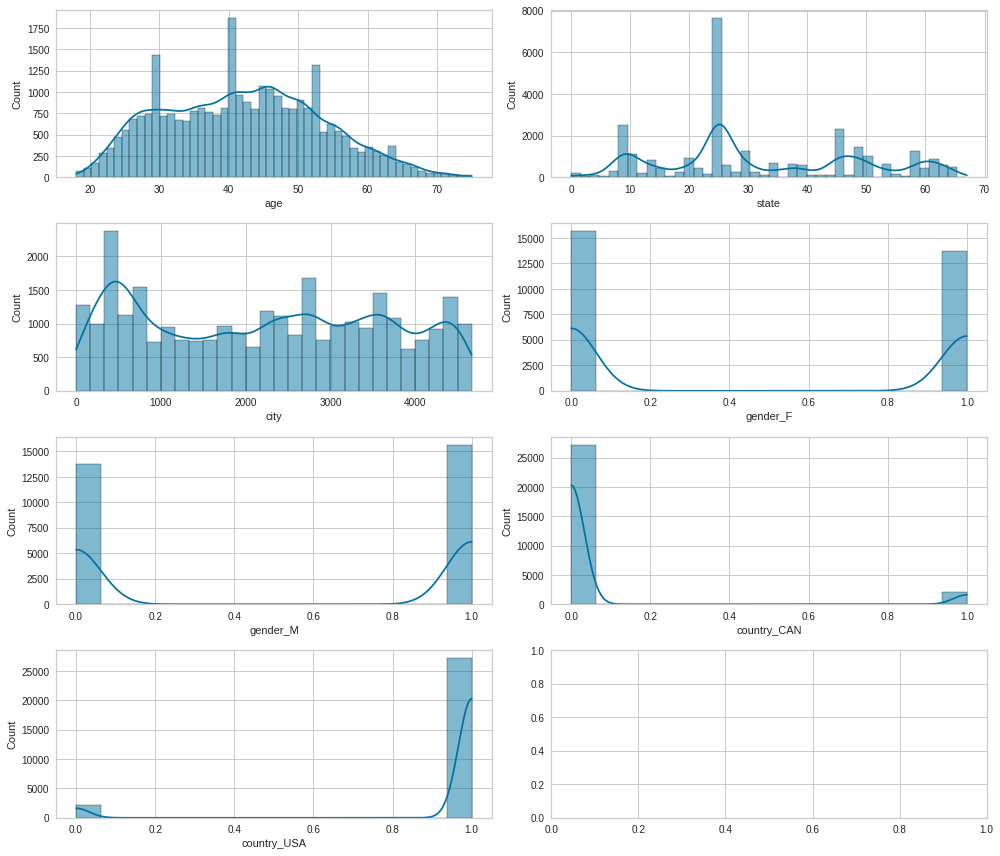

In [ ]:
histplot(df3, np.ceil(len(df3.columns)))

####milestone `df_final`

In [ ]:
df_final = df3.copy()

###minmaxtransform for `age`, `state`, `city`

In [ ]:
df_final[['age','state','city']] = MinMaxScaler(feature_range= (0,1)).fit_transform(df3[['age','state','city']])

In [ ]:
df_final

,age,state,city,gender_F,gender_M,country_CAN,country_USA
9,0.228070,0.134328,0.721210,0,1,0,1
14,0.192982,0.716418,0.696118,0,1,1,0
15,0.210526,0.432836,0.735578,1,0,0,1
24,0.508772,0.791045,0.841947,0,1,1,0
27,0.210526,0.298507,0.142183,0,1,0,1
...,...,...,...,...,...,...,...
31979,0.245614,0.134328,0.451426,0,1,0,1
31980,0.280702,0.373134,0.622989,0,1,0,1
31981,0.052632,0.164179,0.957967,1,0,0,1
31982,0.350877,0.373134,0.603474,1,0,0,1


Text(0.5, 1.0, 'Elbow Curve')

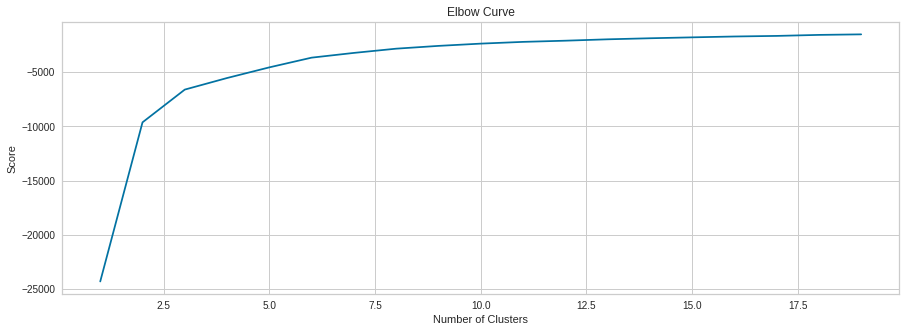

In [ ]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(df_final).score(df_final) for i in range(len(kmeans))] 
score #Opposite of the value of X on the K-means objective.
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

base on chart, we will choose custer = 3

### `clusters` = 3

In [ ]:
cluster_model = KMeans(n_clusters=3).fit(df_final)

cluster_model.labels_

array([1, 2, 0, ..., 0, 0, 1], dtype=int32)

In [ ]:
df['cluster'] = cluster_model.labels_

In [ ]:
df

,gender,age,state,country,city,cluster
9,M,31,CA,USA,Redding,1
14,M,29,ON,CAN,Port Elgin,2
15,F,30,MI,USA,Rochester Hills,0
24,M,47,QC,CAN,St-Jean Baptiste,2
27,M,30,IL,USA,Champaign,1
...,...,...,...,...,...,...
31979,M,32,CA,USA,Larkspur,1
31980,M,34,MA,USA,Norwell,1
31981,F,21,CT,USA,West Simsbury,0
31982,F,38,MA,USA,North Andover,0


###check_insight

In [ ]:
def check_insight(data):

  columns = ['country','gender','state','city']
  fig, ax = plt.subplots(4, figsize=(18,35))
  j=0
  for i in columns:
    temp = data[i].reset_index().drop(['unique','top'], axis=1)
    df_temp = temp.melt('cluster', var_name='cols',  value_name='samples')

    #plot
    sns.barplot(data=df_temp, y='samples', x='cluster',hue='cols',
                 ci="sd", palette="Blues_d",errwidth=0.3, alpha=0.4, ax=ax[j],).set_title(str('{}'.format(i)).upper())
    j+=1

In [ ]:
insight = df.groupby('cluster')[['country','gender','state','city']].describe()
insight

country                    gender  ... state   city                     
          count unique  top   freq  count  ...  freq  count unique      top freq
cluster                                    ...                                  
0         12781      1  USA  12781  12781  ...  3929  12781   2864   Boston  590
1         14426      1  USA  14426  14426  ...  3654  14426   3276   Boston  442
2          2171      1  CAN   2171   2171  ...  1051   2171    518  Toronto  240

[3 rows x 16 columns]

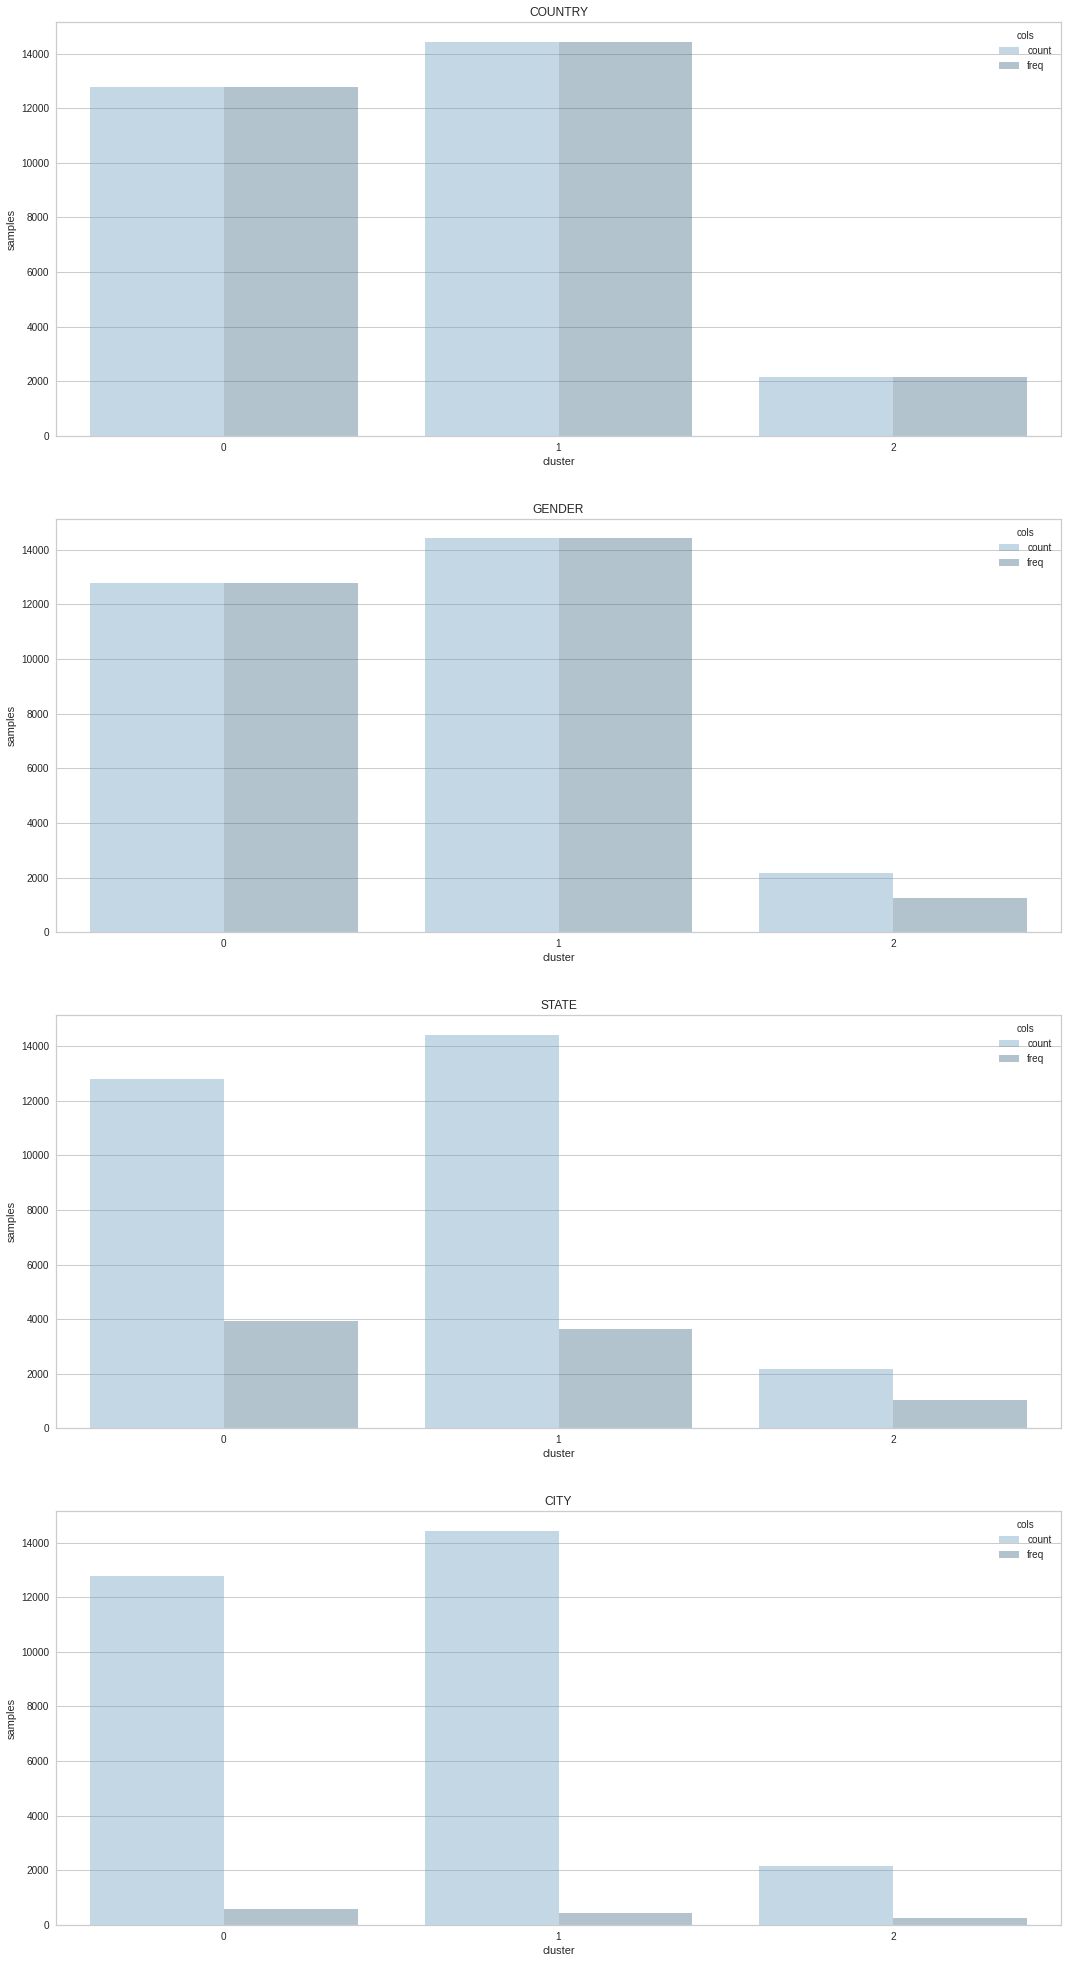

In [ ]:
check_insight(insight)

We can see that in feature `country` and `gender`, numbers of most-appear feature is a same with total samples in specific clusters.

Check with dataframe `insight` , we can see that:

1.   cluster 0 only inclue `gender` = Female,  and `country` = USA
2.   cluster 2 only inclue `gender` = Male,  and `country` = USA

This will reduce the important of other features like `state` or `city`


###`n_clusters` = 8

In [ ]:
cluster_model = KMeans(n_clusters=8).fit(df_final)

cluster_model.labels_

array([0, 5, 1, ..., 1, 1, 3], dtype=int32)

In [ ]:
df['cluster'] = cluster_model.labels_

In [ ]:
insight = df.groupby('cluster')[['country','gender','state','city']].describe()
insight

country                   gender  ... state  city                        
          count unique  top  freq  count  ...  freq count unique         top freq
cluster                                   ...                                    
0          5167      1  USA  5167   5167  ...  1939  5167   1140      Newton  111
1          4764      1  USA  4764   4764  ...  1964  4764   1092  Somerville  144
2          3348      1  USA  3348   3348  ...   459  3348   1043    New York  238
3          3585      1  USA  3585   3585  ...   625  3585   1141    New York  260
4          5674      1  USA  5674   5674  ...  1715  5674   1223      Boston  442
5          1238      1  CAN  1238   1238  ...   572  1238    389     Toronto  124
6          4669      1  USA  4669   4669  ...  1965  4669    933      Boston  590
7           933      1  CAN   933    933  ...   479   933    282     Toronto  116

[8 rows x 16 columns]

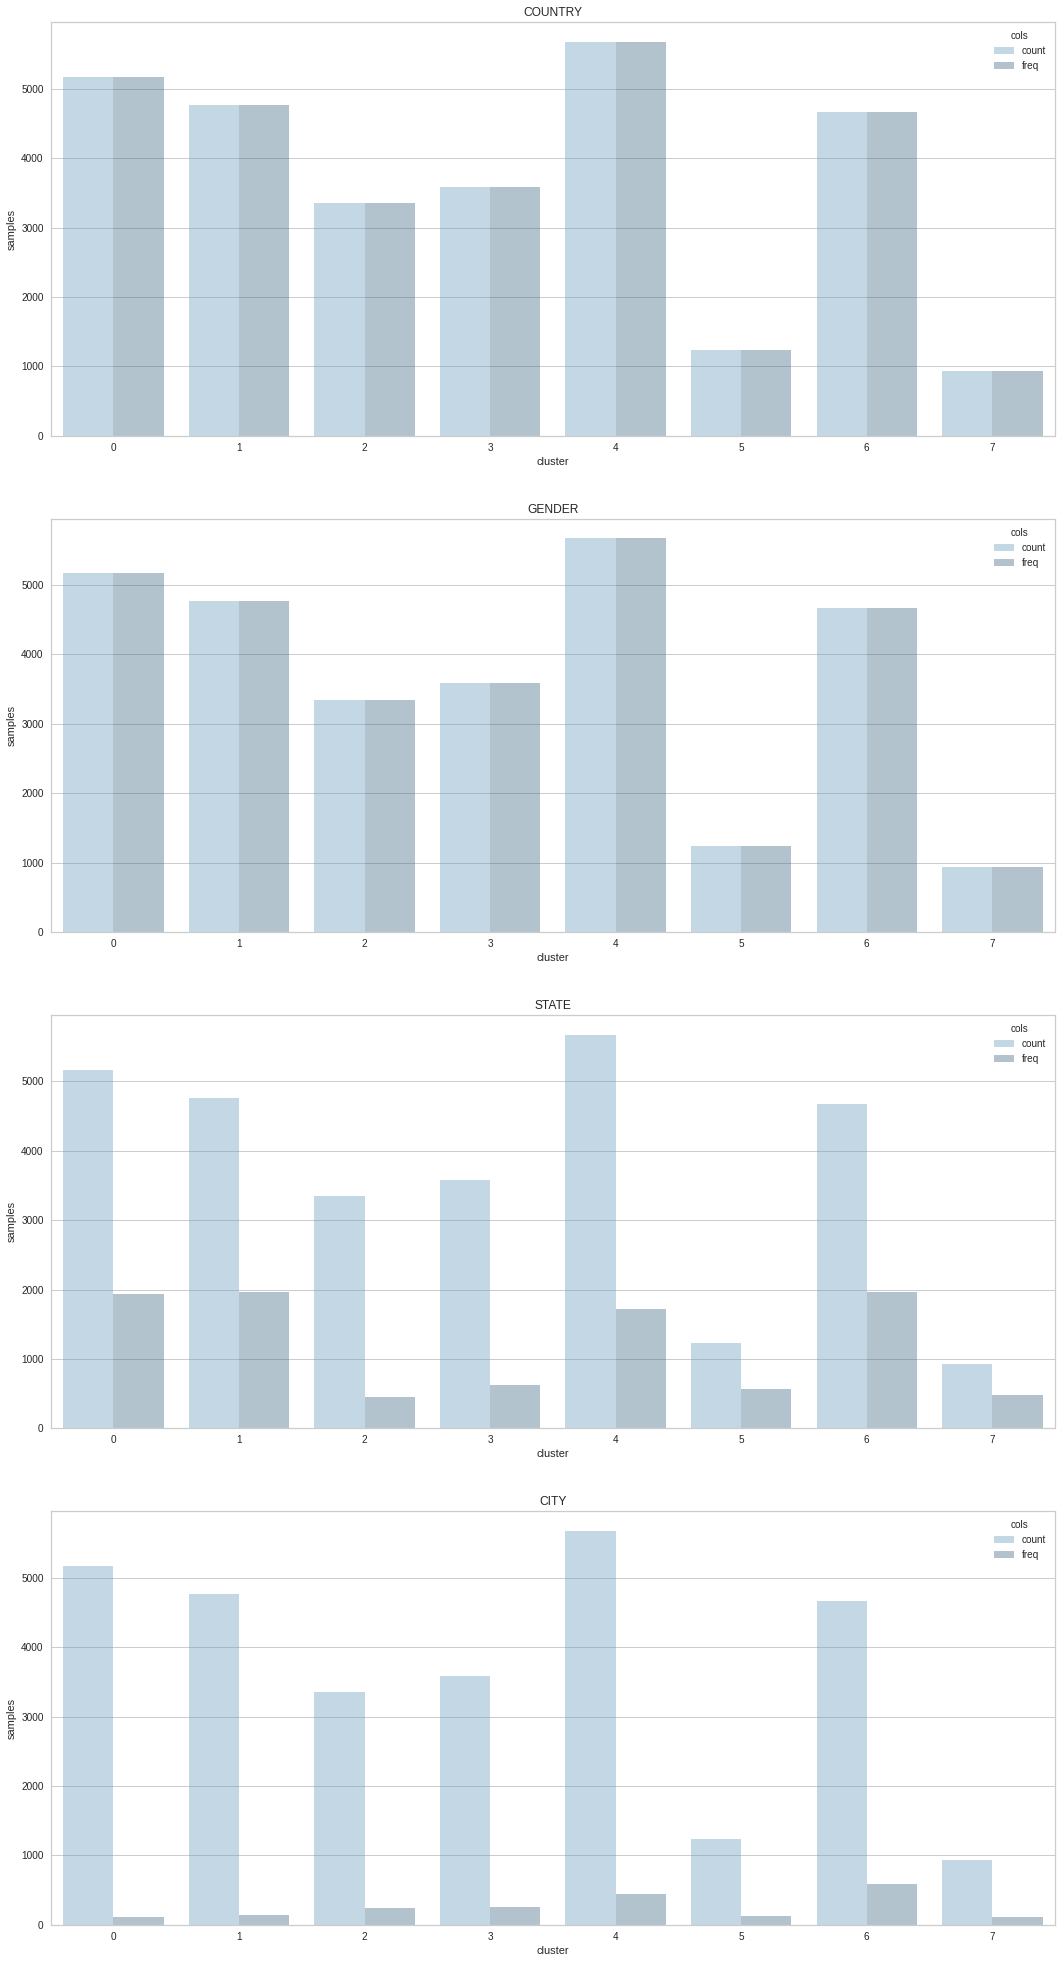

In [ ]:
check_insight(insight)

We have the same result, so we bet that changing algorithms might solve this problem

###save model

We will save model that clusters = 3

In [ ]:
pickle.dump(cluster_model, open("/content/drive/MyDrive/CBD_Robotic/boston_marathon/cluster_model.pkl", "wb"))

In [ ]:
# cd /content/drive/MyDrive/CBD_Robotic/boston_marathon
# cat model_requirements.txt

/content/drive/MyDrive/CBD_Robotic/boston_marathon


#Phase 2: Using Unsupervise model to boston marathon project

##Load model & Import libraries

In [ ]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle
# kmean and elbow curve
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# min-max scaler
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


The data for predict cluster must follow feature's order like this:

`gender`: onehotencode to Male and Female

`country`: onehotencode to USA and CAN

`age`, `state` and `city` in range(0,1)

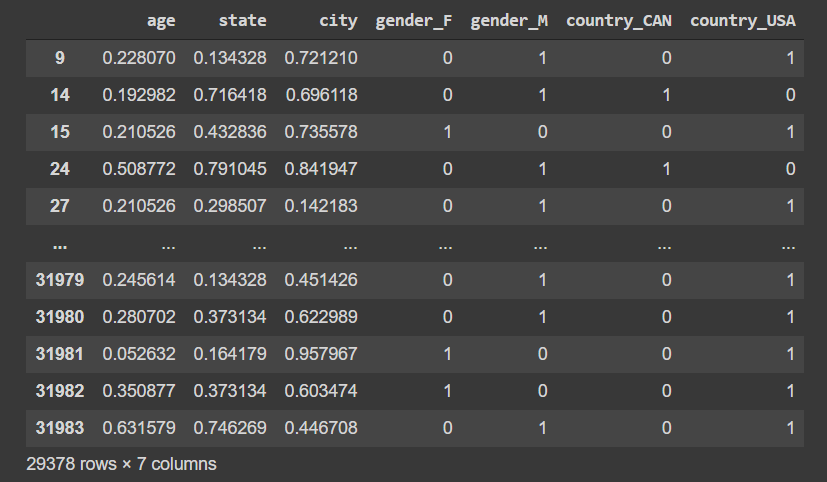

In [ ]:
model = pickle.load(open("/content/drive/MyDrive/CBD_Robotic/boston_marathon/cluster_model.pkl", "rb"))

##Boston Marathon Project

In [ ]:
!git clone https://github.com/llimllib/bostonmarathon

Cloning into 'bostonmarathon'...
remote: Enumerating objects: 339, done.
remote: Total 339 (delta 0), reused 0 (delta 0), pack-reused 339
Receiving objects: 100% (339/339), 55.57 MiB | 20.35 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
df = pd.read_csv('/content/bostonmarathon/results/2014/results.csv')

In [ ]:
df

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31979,50.72,"Anderson, Steve K.",3414,124.02,M,32,211.75,35908,7500,NaN,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,Larkspur,200.22
31980,61.28,"McCarthy, Michael P.",5212,165.02,M,34,302.52,35909,15459,NaN,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,Norwell,285.47
31981,59.00,"Brimmer, Delia C.",5231,157.02,F,21,282.00,35910,10788,NaN,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,West Simsbury,266.30
31982,63.75,"Morganthal, Amy",5800,167.82,F,38,302.73,35911,12009,NaN,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,North Andover,285.87


###Check null values

In [ ]:
null_percent = pd.DataFrame(df.isnull().sum() / len(df), columns=['null_percent'])
null_percent

,null_percent
10k,0.000000
name,0.000000
division,0.000000
25k,0.000000
gender,0.000000
age,0.000000
official,0.000000
bib,0.000000
genderdiv,0.000000
ctz,0.961106


We remove features that have threshold > 0.3

In [ ]:
temp = []
for feature in null_percent.iterrows():
  if float(feature[1]) > 0.3:
     temp.append(feature[0])

temp

['ctz']

We don't have any features out of our criteria

In [ ]:
df = df.drop(temp, axis=1)
df = df.dropna()

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83
1,17.12,"Cassidy, Josh R.",13,48.88,M,29,87.40,W8,13,72.83,13,3.35,ON,60.82,8.02,40.20,38.02,CAN,Port Elgin,82.38
2,33.93,"Linden, Desiree",10,85.03,F,30,143.90,F8,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,Rochester Hills,136.47
3,18.30,"Filteau, Michel",14,50.33,M,47,89.40,W13,14,74.95,14,3.42,QC,62.33,8.67,41.80,39.63,CAN,St-Jean Baptiste,84.48
4,18.78,"Kim, Gyu Dae",15,50.33,M,30,89.52,W14,15,75.02,15,3.42,IL,62.72,8.98,41.82,39.65,USA,Champaign,84.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29403,50.72,"Anderson, Steve K.",3414,124.02,M,32,211.75,35908,7500,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,Larkspur,200.22
29404,61.28,"McCarthy, Michael P.",5212,165.02,M,34,302.52,35909,15459,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,Norwell,285.47
29405,59.00,"Brimmer, Delia C.",5231,157.02,F,21,282.00,35910,10788,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,West Simsbury,266.30
29406,63.75,"Morganthal, Amy",5800,167.82,F,38,302.73,35911,12009,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,North Andover,285.87


### replace weird values and convert some features to numeric

We can see some weird values in `10k`, `20k`, etc...

In [ ]:
df['10k'][2828]

'-'

remove and convert

In [ ]:
temp = ['5k','10k','20k','25k','30k','35k','40k','half']
for i in temp:
  #drop weird values
  df.drop(df[df[i] == '-'].index, inplace=True)
  #covert object type to numeric
  df[i] = pd.to_numeric(df[i])

In [ ]:
df

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83
1,17.12,"Cassidy, Josh R.",13,48.88,M,29,87.40,W8,13,72.83,13,3.35,ON,60.82,8.02,40.20,38.02,CAN,Port Elgin,82.38
2,33.93,"Linden, Desiree",10,85.03,F,30,143.90,F8,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,Rochester Hills,136.47
3,18.30,"Filteau, Michel",14,50.33,M,47,89.40,W13,14,74.95,14,3.42,QC,62.33,8.67,41.80,39.63,CAN,St-Jean Baptiste,84.48
4,18.78,"Kim, Gyu Dae",15,50.33,M,30,89.52,W14,15,75.02,15,3.42,IL,62.72,8.98,41.82,39.65,USA,Champaign,84.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29403,50.72,"Anderson, Steve K.",3414,124.02,M,32,211.75,35908,7500,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,Larkspur,200.22
29404,61.28,"McCarthy, Michael P.",5212,165.02,M,34,302.52,35909,15459,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,Norwell,285.47
29405,59.00,"Brimmer, Delia C.",5231,157.02,F,21,282.00,35910,10788,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,West Simsbury,266.30
29406,63.75,"Morganthal, Amy",5800,167.82,F,38,302.73,35911,12009,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,North Andover,285.87


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29103 entries, 0 to 29407
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   10k        29103 non-null  float64
 1   name       29103 non-null  object 
 2   division   29103 non-null  int64  
 3   25k        29103 non-null  float64
 4   gender     29103 non-null  object 
 5   age        29103 non-null  int64  
 6   official   29103 non-null  float64
 7   bib        29103 non-null  object 
 8   genderdiv  29103 non-null  int64  
 9   35k        29103 non-null  float64
 10  overall    29103 non-null  int64  
 11  pace       29103 non-null  float64
 12  state      29103 non-null  object 
 13  30k        29103 non-null  float64
 14  5k         29103 non-null  float64
 15  half       29103 non-null  float64
 16  20k        29103 non-null  float64
 17  country    29103 non-null  object 
 18  city       29103 non-null  object 
 19  40k        29103 non-null  float64
dtypes: flo

###plot some insight

In [ ]:
df

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83
1,17.12,"Cassidy, Josh R.",13,48.88,M,29,87.40,W8,13,72.83,13,3.35,ON,60.82,8.02,40.20,38.02,CAN,Port Elgin,82.38
2,33.93,"Linden, Desiree",10,85.03,F,30,143.90,F8,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,Rochester Hills,136.47
3,18.30,"Filteau, Michel",14,50.33,M,47,89.40,W13,14,74.95,14,3.42,QC,62.33,8.67,41.80,39.63,CAN,St-Jean Baptiste,84.48
4,18.78,"Kim, Gyu Dae",15,50.33,M,30,89.52,W14,15,75.02,15,3.42,IL,62.72,8.98,41.82,39.65,USA,Champaign,84.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29403,50.72,"Anderson, Steve K.",3414,124.02,M,32,211.75,35908,7500,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,Larkspur,200.22
29404,61.28,"McCarthy, Michael P.",5212,165.02,M,34,302.52,35909,15459,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,Norwell,285.47
29405,59.00,"Brimmer, Delia C.",5231,157.02,F,21,282.00,35910,10788,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,West Simsbury,266.30
29406,63.75,"Morganthal, Amy",5800,167.82,F,38,302.73,35911,12009,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,North Andover,285.87


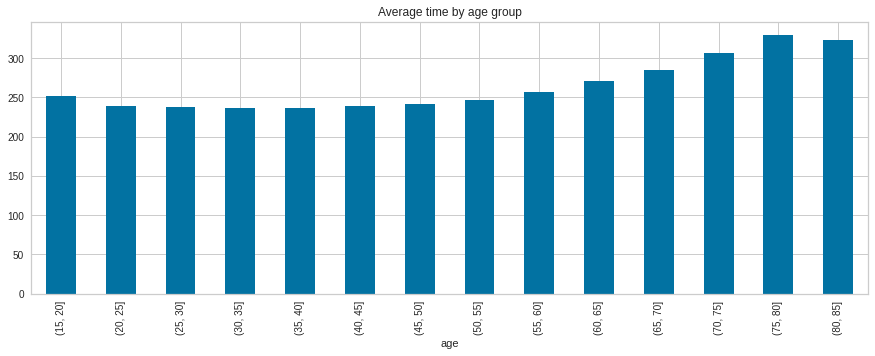

In [ ]:
df['official'].groupby(pd.cut(df['age'], range(15,90,5))).aggregate(np.average).plot(kind="bar", title="Average time by age group")

We can see that the the age range that have greatest time is from 20 to 40

after that, the time spend is higher per higher age

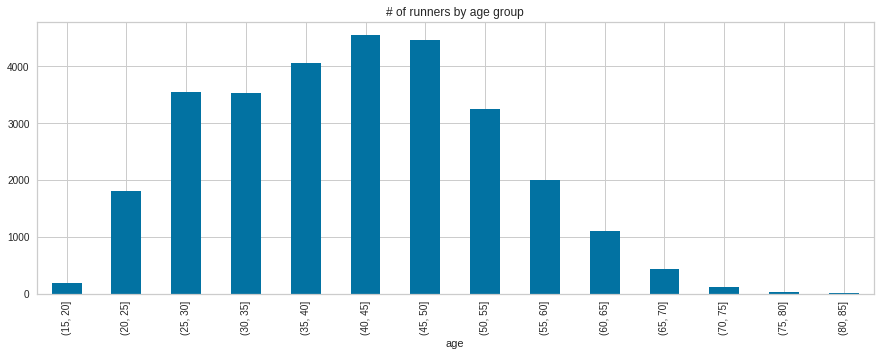

In [ ]:
df['official'].groupby(pd.cut(df['age'], range(15,90,5))).aggregate(len).plot(kind="bar", title="# of runners by age group")

The numbers of age from 15 to 20, and from above 65 is really few

it maybe occur outliers

### find outliers

In [ ]:
df2 = df.copy()

In [ ]:
df2

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83
1,17.12,"Cassidy, Josh R.",13,48.88,M,29,87.40,W8,13,72.83,13,3.35,ON,60.82,8.02,40.20,38.02,CAN,Port Elgin,82.38
2,33.93,"Linden, Desiree",10,85.03,F,30,143.90,F8,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,Rochester Hills,136.47
3,18.30,"Filteau, Michel",14,50.33,M,47,89.40,W13,14,74.95,14,3.42,QC,62.33,8.67,41.80,39.63,CAN,St-Jean Baptiste,84.48
4,18.78,"Kim, Gyu Dae",15,50.33,M,30,89.52,W14,15,75.02,15,3.42,IL,62.72,8.98,41.82,39.65,USA,Champaign,84.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29403,50.72,"Anderson, Steve K.",3414,124.02,M,32,211.75,35908,7500,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,Larkspur,200.22
29404,61.28,"McCarthy, Michael P.",5212,165.02,M,34,302.52,35909,15459,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,Norwell,285.47
29405,59.00,"Brimmer, Delia C.",5231,157.02,F,21,282.00,35910,10788,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,West Simsbury,266.30
29406,63.75,"Morganthal, Amy",5800,167.82,F,38,302.73,35911,12009,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,North Andover,285.87


In [ ]:
df_temp = df2.drop(['name','gender','bib','country'], axis=1)

#convert categories
df_temp['state'] = df_temp.state.astype('category').cat.codes
df_temp['city'] = df_temp.city.astype('category').cat.codes

In [ ]:
df_temp

,10k,division,25k,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,city,40k
0,30.48,20,77.68,31,137.83,20,112.27,20,5.27,9,94.78,15.15,65.23,61.78,3355,129.83
1,17.12,13,48.88,29,87.40,13,72.83,13,3.35,48,60.82,8.02,40.20,38.02,3238,82.38
2,33.93,10,85.03,30,143.90,10,119.68,46,5.50,29,102.40,16.92,71.68,67.92,3422,136.47
3,18.30,14,50.33,47,89.40,14,74.95,14,3.42,53,62.33,8.67,41.80,39.63,3912,84.48
4,18.78,15,50.33,30,89.52,15,75.02,15,3.42,20,62.72,8.98,41.82,39.65,662,84.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29403,50.72,3414,124.02,32,211.75,7500,174.90,9849,8.08,9,148.65,26.13,104.78,99.55,2101,200.22
29404,61.28,5212,165.02,34,302.52,15459,244.70,27456,11.55,25,203.43,31.07,135.85,128.37,2899,285.47
29405,59.00,5231,157.02,21,282.00,10788,229.62,25092,10.77,11,192.65,28.18,130.57,123.33,4451,266.30
29406,63.75,5800,167.82,38,302.73,12009,247.18,27476,11.55,25,207.52,30.98,137.03,129.90,2808,285.87


In [ ]:
#find IQR
Q1 = df_temp.quantile(0.25)
Q3 = df_temp.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

#find ouliers
count_outlier = []

for i in range(len(IQR)):
  index = df_temp[(df_temp[IQR.index[i]] < (Q1[i] - 1.5 * IQR[i])) |
              (df_temp[IQR.index[i]] > (Q3[i] + 1.5 * IQR[i]))].index
  count_outlier.append(len(index))

percent = []
for count in count_outlier:
    percent.append(100*(count/(df_temp.shape[0])))

#ouliers
outlier = pd.DataFrame({'count': count_outlier, 'percent':percent}, index=IQR.index)
outlier

10k             11.62
division      2080.00
25k             32.51
age             17.00
official        67.33
genderdiv     7954.00
35k             52.72
overall      15871.50
pace             2.56
state           25.00
30k             42.05
5k               5.77
half            26.02
20k             24.58
city          2599.00
40k             63.50
dtype: float64


,count,percent
10k,351,1.206061
division,1149,3.948047
25k,660,2.267807
age,29,0.099646
official,449,1.542796
genderdiv,0,0.000000
35k,595,2.044463
overall,0,0.000000
pace,454,1.559977
state,0,0.000000


In [ ]:
for i in range(len(IQR)):
    index = list(df_temp[(df_temp[IQR.index[i]] < (Q1[i] - 1.5 * IQR[i])) |
              (df_temp[IQR.index[i]] > (Q3[i] + 1.5 * IQR[i]))].index)
    df_temp.drop(index, inplace=True)

In [ ]:
df_temp

,10k,division,25k,age,official,genderdiv,35k,overall,pace,state,30k,5k,half,20k,city,40k
0,30.48,20,77.68,31,137.83,20,112.27,20,5.27,9,94.78,15.15,65.23,61.78,3355,129.83
2,33.93,10,85.03,30,143.90,10,119.68,46,5.50,29,102.40,16.92,71.68,67.92,3422,136.47
6,32.57,7,82.43,32,142.03,7,116.63,37,5.43,49,99.33,16.20,69.45,65.82,3257,134.00
8,30.52,16,77.58,35,136.10,16,110.90,16,5.20,7,93.82,15.17,65.28,61.83,4194,128.17
10,30.48,1,76.00,38,128.62,1,106.62,1,4.92,9,91.17,15.15,64.35,61.08,3563,121.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29403,50.72,3414,124.02,32,211.75,7500,174.90,9849,8.08,9,148.65,26.13,104.78,99.55,2101,200.22
29404,61.28,5212,165.02,34,302.52,15459,244.70,27456,11.55,25,203.43,31.07,135.85,128.37,2899,285.47
29405,59.00,5231,157.02,21,282.00,10788,229.62,25092,10.77,11,192.65,28.18,130.57,123.33,4451,266.30
29406,63.75,5800,167.82,38,302.73,12009,247.18,27476,11.55,25,207.52,30.98,137.03,129.90,2808,285.87


####milestone `df3`

In [ ]:
df3 = df2.drop(index=df2.drop(index=df_temp.index).index).reset_index(drop=True)

In [ ]:
df3

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83
1,33.93,"Linden, Desiree",10,85.03,F,30,143.90,F8,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,Rochester Hills,136.47
2,32.57,"Flanagan, Shalane",7,82.43,F,32,142.03,F17,7,116.63,37,5.43,OR,99.33,16.20,69.45,65.82,USA,Portland,134.00
3,30.52,"Abdirahman, Abdi",16,77.58,M,35,136.10,18,16,110.90,16,5.20,AZ,93.82,15.17,65.28,61.83,USA,Tucson,128.17
4,30.48,"Keflezighi, Meb",1,76.00,M,38,128.62,19,1,106.62,1,4.92,CA,91.17,15.15,64.35,61.08,USA,San Diego,121.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27356,50.72,"Anderson, Steve K.",3414,124.02,M,32,211.75,35908,7500,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,Larkspur,200.22
27357,61.28,"McCarthy, Michael P.",5212,165.02,M,34,302.52,35909,15459,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,Norwell,285.47
27358,59.00,"Brimmer, Delia C.",5231,157.02,F,21,282.00,35910,10788,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,West Simsbury,266.30
27359,63.75,"Morganthal, Amy",5800,167.82,F,38,302.73,35911,12009,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,North Andover,285.87


###divide into train and supervise dataset

In [ ]:
df_train = df3[['name','gender','age','country','city','state']]
df_train

,name,gender,age,country,city,state
0,"Hall, Ryan",M,31,USA,Redding,CA
1,"Linden, Desiree",F,30,USA,Rochester Hills,MI
2,"Flanagan, Shalane",F,32,USA,Portland,OR
3,"Abdirahman, Abdi",M,35,USA,Tucson,AZ
4,"Keflezighi, Meb",M,38,USA,San Diego,CA
...,...,...,...,...,...,...
27356,"Anderson, Steve K.",M,32,USA,Larkspur,CA
27357,"McCarthy, Michael P.",M,34,USA,Norwell,MA
27358,"Brimmer, Delia C.",F,21,USA,West Simsbury,CT
27359,"Morganthal, Amy",F,38,USA,North Andover,MA


In [ ]:
df_supervise = df3.drop(df_train.columns, axis=1)
df_supervise

,10k,division,25k,official,bib,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,30.48,20,77.68,137.83,6,20,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83
1,33.93,10,85.03,143.90,F8,10,119.68,46,5.50,102.40,16.92,71.68,67.92,136.47
2,32.57,7,82.43,142.03,F17,7,116.63,37,5.43,99.33,16.20,69.45,65.82,134.00
3,30.52,16,77.58,136.10,18,16,110.90,16,5.20,93.82,15.17,65.28,61.83,128.17
4,30.48,1,76.00,128.62,19,1,106.62,1,4.92,91.17,15.15,64.35,61.08,121.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27356,50.72,3414,124.02,211.75,35908,7500,174.90,9849,8.08,148.65,26.13,104.78,99.55,200.22
27357,61.28,5212,165.02,302.52,35909,15459,244.70,27456,11.55,203.43,31.07,135.85,128.37,285.47
27358,59.00,5231,157.02,282.00,35910,10788,229.62,25092,10.77,192.65,28.18,130.57,123.33,266.30
27359,63.75,5800,167.82,302.73,35911,12009,247.18,27476,11.55,207.52,30.98,137.03,129.90,285.87


create onehot dataset for `gender` and `country`

In [ ]:
df_gender = pd.get_dummies(df_train.gender, prefix='gender')
df_country = pd.get_dummies(df_train.country, prefix='country')

In [ ]:
df_gender

,gender_F,gender_M
0,0,1
1,1,0
2,1,0
3,0,1
4,0,1
...,...,...
27356,0,1
27357,0,1
27358,1,0
27359,1,0


Join onehot features to `df_train`

In [ ]:
df_train = df_train.join([df_gender, df_country]).drop(['gender','country'],axis=1)

In [ ]:
df_train['state'] = df_train.state.astype('category').cat.codes
df_train['city'] = df_train.city.astype('category').cat.codes

#drop `name`
df_train = df_train.drop(['name'],axis=1)

In [ ]:
df_train

,age,city,state,gender_F,gender_M,country_CAN,country_USA
0,31,3306,9,0,1,0,1
1,30,3373,29,1,0,0,1
2,32,3211,49,1,0,0,1
3,35,4135,7,0,1,0,1
4,38,3514,9,0,1,0,1
...,...,...,...,...,...,...,...
27356,32,2067,9,0,1,0,1
27357,34,2855,25,0,1,0,1
27358,21,4387,11,1,0,0,1
27359,38,2766,25,1,0,0,1


apply MinMaxScaler to `age`, `state`, `city`

In [ ]:
df_train[['age','state','city']] = MinMaxScaler(feature_range= (0,1)).fit_transform(df_train[['age','state','city']])

In [ ]:
df_train

,age,city,state,gender_F,gender_M,country_CAN,country_USA
0,0.228070,0.721676,0.134328,0,1,0,1
1,0.210526,0.736302,0.432836,1,0,0,1
2,0.245614,0.700939,0.731343,1,0,0,1
3,0.298246,0.902641,0.104478,0,1,0,1
4,0.350877,0.767081,0.134328,0,1,0,1
...,...,...,...,...,...,...,...
27356,0.245614,0.451212,0.134328,0,1,0,1
27357,0.280702,0.623226,0.373134,0,1,0,1
27358,0.052632,0.957651,0.164179,1,0,0,1
27359,0.350877,0.603798,0.373134,1,0,0,1


###Predict clusters

Recall that:

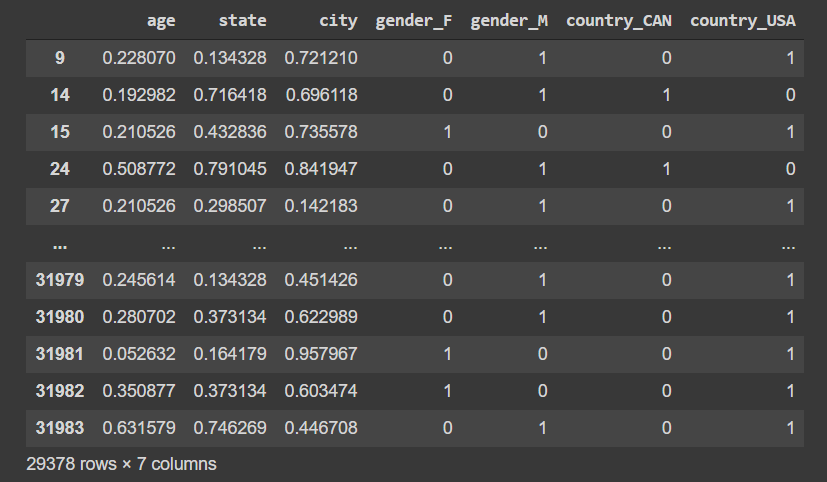

We can see that the order is not correct, so that we should reorder columns:

In [ ]:
df_train2 = df_train.reindex(columns=['age','state','city','gender_F','gender_M','country_CAN','country_USA'])

In [ ]:
df_train2

,age,state,city,gender_F,gender_M,country_CAN,country_USA
0,0.228070,0.134328,0.721676,0,1,0,1
1,0.210526,0.432836,0.736302,1,0,0,1
2,0.245614,0.731343,0.700939,1,0,0,1
3,0.298246,0.104478,0.902641,0,1,0,1
4,0.350877,0.134328,0.767081,0,1,0,1
...,...,...,...,...,...,...,...
27356,0.245614,0.134328,0.451212,0,1,0,1
27357,0.280702,0.373134,0.623226,0,1,0,1
27358,0.052632,0.164179,0.957651,1,0,0,1
27359,0.350877,0.373134,0.603798,1,0,0,1


Everythings is ok now and be ready to predict

In [ ]:
predict = model.predict(df_train2)

####milestone `df4`

In [ ]:
df4 = df3.copy()

In [ ]:
df4['cluster'] = predict


In [ ]:
df4

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,cluster
0,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83,2
1,33.93,"Linden, Desiree",10,85.03,F,30,143.90,F8,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,Rochester Hills,136.47,0
2,32.57,"Flanagan, Shalane",7,82.43,F,32,142.03,F17,7,116.63,37,5.43,OR,99.33,16.20,69.45,65.82,USA,Portland,134.00,0
3,30.52,"Abdirahman, Abdi",16,77.58,M,35,136.10,18,16,110.90,16,5.20,AZ,93.82,15.17,65.28,61.83,USA,Tucson,128.17,2
4,30.48,"Keflezighi, Meb",1,76.00,M,38,128.62,19,1,106.62,1,4.92,CA,91.17,15.15,64.35,61.08,USA,San Diego,121.82,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27356,50.72,"Anderson, Steve K.",3414,124.02,M,32,211.75,35908,7500,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,Larkspur,200.22,2
27357,61.28,"McCarthy, Michael P.",5212,165.02,M,34,302.52,35909,15459,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,Norwell,285.47,2
27358,59.00,"Brimmer, Delia C.",5231,157.02,F,21,282.00,35910,10788,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,West Simsbury,266.30,0
27359,63.75,"Morganthal, Amy",5800,167.82,F,38,302.73,35911,12009,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,North Andover,285.87,0


create `percent_cluster` and add it to `df4`

In [ ]:
temp = df4.cluster.value_counts(normalize=True) * 100

In [ ]:
percent_cluster = temp.to_frame().reset_index()
percent_cluster.rename(columns={"cluster": "percent_cluster"}, inplace=True)
percent_cluster

,index,percent_cluster
0,2,51.025182
1,0,41.171741
2,1,7.803077


In [ ]:
df4 = pd.merge(df4, percent_cluster, left_on='cluster', right_on='index', how='left').drop(['index'], axis=1)

df4

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,cluster,percent_cluster
0,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,112.27,20,5.27,CA,94.78,15.15,65.23,61.78,USA,Redding,129.83,2,51.025182
1,33.93,"Linden, Desiree",10,85.03,F,30,143.90,F8,10,119.68,46,5.50,MI,102.40,16.92,71.68,67.92,USA,Rochester Hills,136.47,0,41.171741
2,32.57,"Flanagan, Shalane",7,82.43,F,32,142.03,F17,7,116.63,37,5.43,OR,99.33,16.20,69.45,65.82,USA,Portland,134.00,0,41.171741
3,30.52,"Abdirahman, Abdi",16,77.58,M,35,136.10,18,16,110.90,16,5.20,AZ,93.82,15.17,65.28,61.83,USA,Tucson,128.17,2,51.025182
4,30.48,"Keflezighi, Meb",1,76.00,M,38,128.62,19,1,106.62,1,4.92,CA,91.17,15.15,64.35,61.08,USA,San Diego,121.82,2,51.025182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27356,50.72,"Anderson, Steve K.",3414,124.02,M,32,211.75,35908,7500,174.90,9849,8.08,CA,148.65,26.13,104.78,99.55,USA,Larkspur,200.22,2,51.025182
27357,61.28,"McCarthy, Michael P.",5212,165.02,M,34,302.52,35909,15459,244.70,27456,11.55,MA,203.43,31.07,135.85,128.37,USA,Norwell,285.47,2,51.025182
27358,59.00,"Brimmer, Delia C.",5231,157.02,F,21,282.00,35910,10788,229.62,25092,10.77,CT,192.65,28.18,130.57,123.33,USA,West Simsbury,266.30,0,41.171741
27359,63.75,"Morganthal, Amy",5800,167.82,F,38,302.73,35911,12009,247.18,27476,11.55,MA,207.52,30.98,137.03,129.90,USA,North Andover,285.87,0,41.171741


###analyse supervise data

We add `age`, `cluster`, `percent_cluster` to `df_supervise`

In [ ]:
df_supervise[['age','cluster','percent_cluster']] = df4[['age','cluster','percent_cluster']]

#remove `bib`
df_supervise.drop(['bib'], axis=1, inplace=True)

In [ ]:
df_supervise

,10k,division,25k,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,age,cluster,percent_cluster
0,30.48,20,77.68,137.83,20,112.27,20,5.27,94.78,15.15,65.23,61.78,129.83,31,2,51.025182
1,33.93,10,85.03,143.90,10,119.68,46,5.50,102.40,16.92,71.68,67.92,136.47,30,0,41.171741
2,32.57,7,82.43,142.03,7,116.63,37,5.43,99.33,16.20,69.45,65.82,134.00,32,0,41.171741
3,30.52,16,77.58,136.10,16,110.90,16,5.20,93.82,15.17,65.28,61.83,128.17,35,2,51.025182
4,30.48,1,76.00,128.62,1,106.62,1,4.92,91.17,15.15,64.35,61.08,121.82,38,2,51.025182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27356,50.72,3414,124.02,211.75,7500,174.90,9849,8.08,148.65,26.13,104.78,99.55,200.22,32,2,51.025182
27357,61.28,5212,165.02,302.52,15459,244.70,27456,11.55,203.43,31.07,135.85,128.37,285.47,34,2,51.025182
27358,59.00,5231,157.02,282.00,10788,229.62,25092,10.77,192.65,28.18,130.57,123.33,266.30,21,0,41.171741
27359,63.75,5800,167.82,302.73,12009,247.18,27476,11.55,207.52,30.98,137.03,129.90,285.87,38,0,41.171741


In [ ]:
df_supervise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27361 entries, 0 to 27360
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   10k              27361 non-null  float64
 1   division         27361 non-null  int64  
 2   25k              27361 non-null  float64
 3   official         27361 non-null  float64
 4   genderdiv        27361 non-null  int64  
 5   35k              27361 non-null  float64
 6   overall          27361 non-null  int64  
 7   pace             27361 non-null  float64
 8   30k              27361 non-null  float64
 9   5k               27361 non-null  float64
 10  half             27361 non-null  float64
 11  20k              27361 non-null  float64
 12  40k              27361 non-null  float64
 13  age              27361 non-null  int64  
 14  cluster          27361 non-null  int32  
 15  percent_cluster  27361 non-null  float64
dtypes: float64(11), int32(1), int64(4)
memory usage: 3.2 MB


### group columns by cluster and calculate mean of all columns

In [ ]:
df_bycluster = df_supervise.groupby("cluster").mean()

df_bycluster = df_bycluster.reset_index()

In [ ]:
#fill color for values
cm = sns.light_palette("green", as_cmap=True)

df_bycluster2 = df_bycluster.style.background_gradient(cmap=cm)

In [ ]:
df_bycluster2

,cluster,10k,division,25k,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,age,percent_cluster
0,0,52.917228,1888.130581,136.418772,244.303661,6484.903684,198.919675,17172.930315,9.326208,166.899719,26.332346,113.756180,107.762177,230.713735,39.792277,41.171741
1,1,49.424956,1154.593911,126.772501,227.814604,6988.703044,184.812450,13580.409836,8.697222,155.037255,24.623977,105.918052,100.343644,214.788689,47.028103,7.803077
2,2,49.286995,1796.564286,126.699694,230.972605,8663.254280,186.177461,13685.012177,8.817674,155.414152,24.580988,105.654162,100.061282,217.516083,43.722083,51.025182


We see that cluster 0 usually have higher time to finish race, but `age` in this cluser is lowest (mean = 39,8)

cluster 1 and cluster 2 doesn't have too much difference in time finish in all race, most of features of cluster 2 is a bit higher, contrast with `age`

In [ ]:
def barplot(data, nums_feature):
  ''' data: dataframe
  nums_feature: number of features (must be even) '''
  w = int(np.ceil(nums_feature / 2))
  fig,ax = plt.subplots(w, 2, figsize=(14,20)) 
  i=1 
  try:
    for x in range(w):
        for y in range(2):
            sns.barplot(data=data, x='cluster', y=data[data.columns[i]] ,
                        ci="sd", palette="dark", alpha=0.4, ax=ax[x,y])
            i += 1
  except IndexError:
    pass
  plt.tight_layout()
  plt.show()

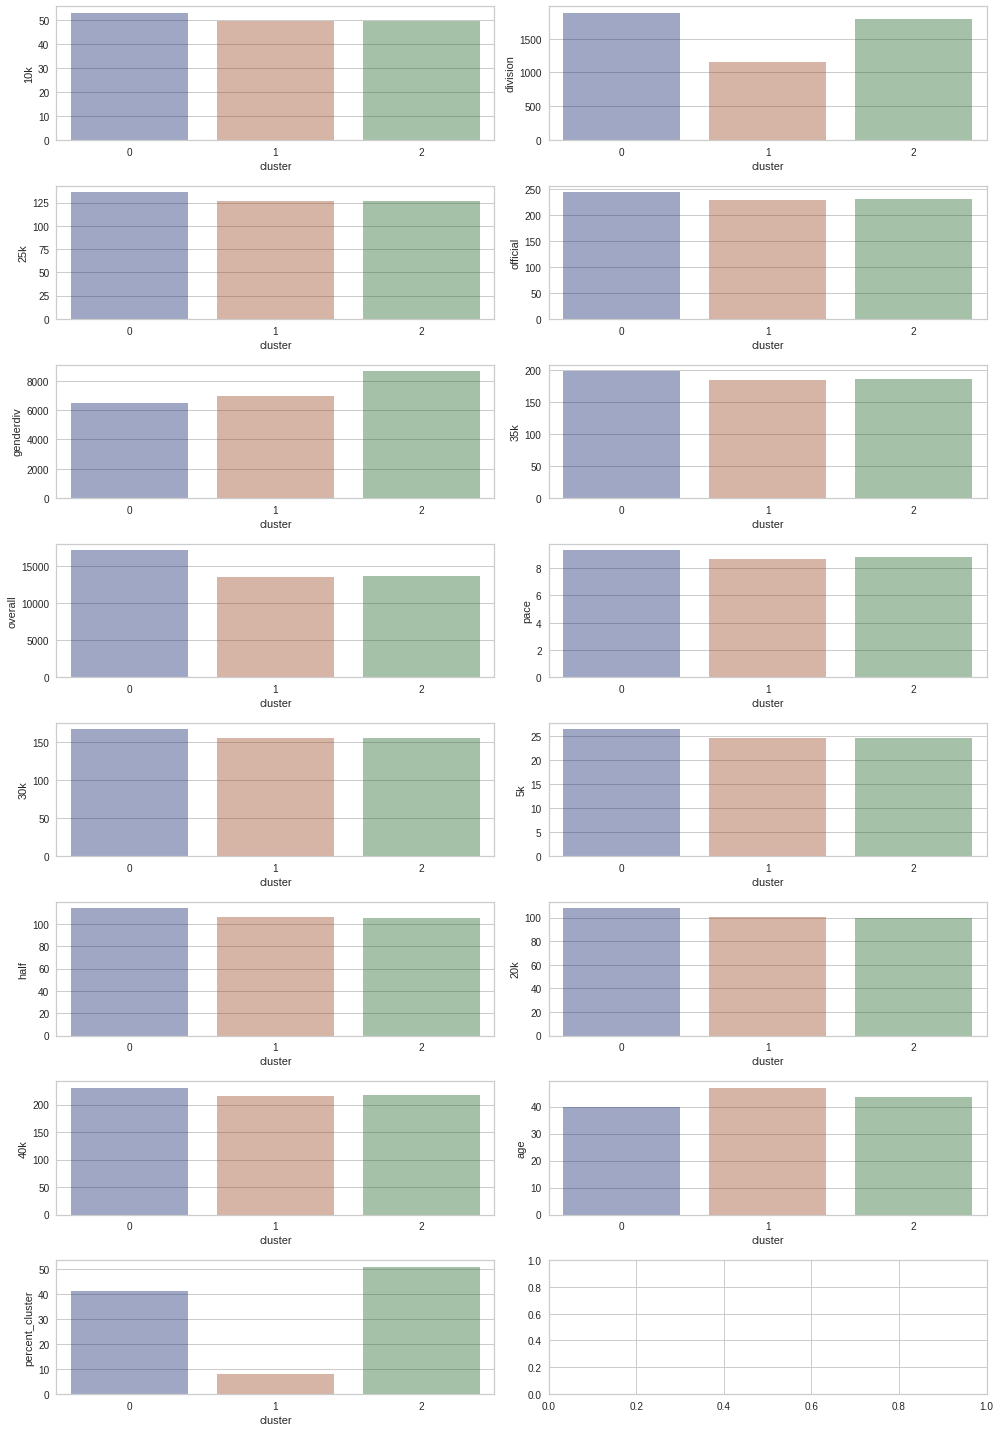

In [ ]:
barplot(df_bycluster, np.ceil(len(df_bycluster.columns)))

###check_insight

In [ ]:
def check_insight(data):

  columns = ['country','gender','state','city']
  fig, ax = plt.subplots(4, figsize=(18,35))
  j=0
  for i in columns:
    temp = data[i].reset_index().drop(['unique','top'], axis=1)
    df_temp = temp.melt('cluster', var_name='cols',  value_name='samples')

    #plot
    sns.barplot(data=df_temp, y='samples', x='cluster',hue='cols',
                 ci="sd", palette="Blues_d",errwidth=0.3, alpha=0.4, ax=ax[j],).set_title(str('{}'.format(i)).upper())
    j+=1

In [ ]:
insight = df4.groupby('cluster')[['country','gender','state','city']].describe()
insight

country                    gender  ... state   city                     
          count unique  top   freq  count  ...  freq  count unique      top freq
cluster                                    ...                                  
0         11265      1  USA  11265  11265  ...  2878  11265   2761   Boston  429
1          2135      1  CAN   2135   2135  ...  1029   2135    514  Toronto  234
2         13961      1  USA  13961  13961  ...  3415  13961   3237   Boston  416

[3 rows x 16 columns]

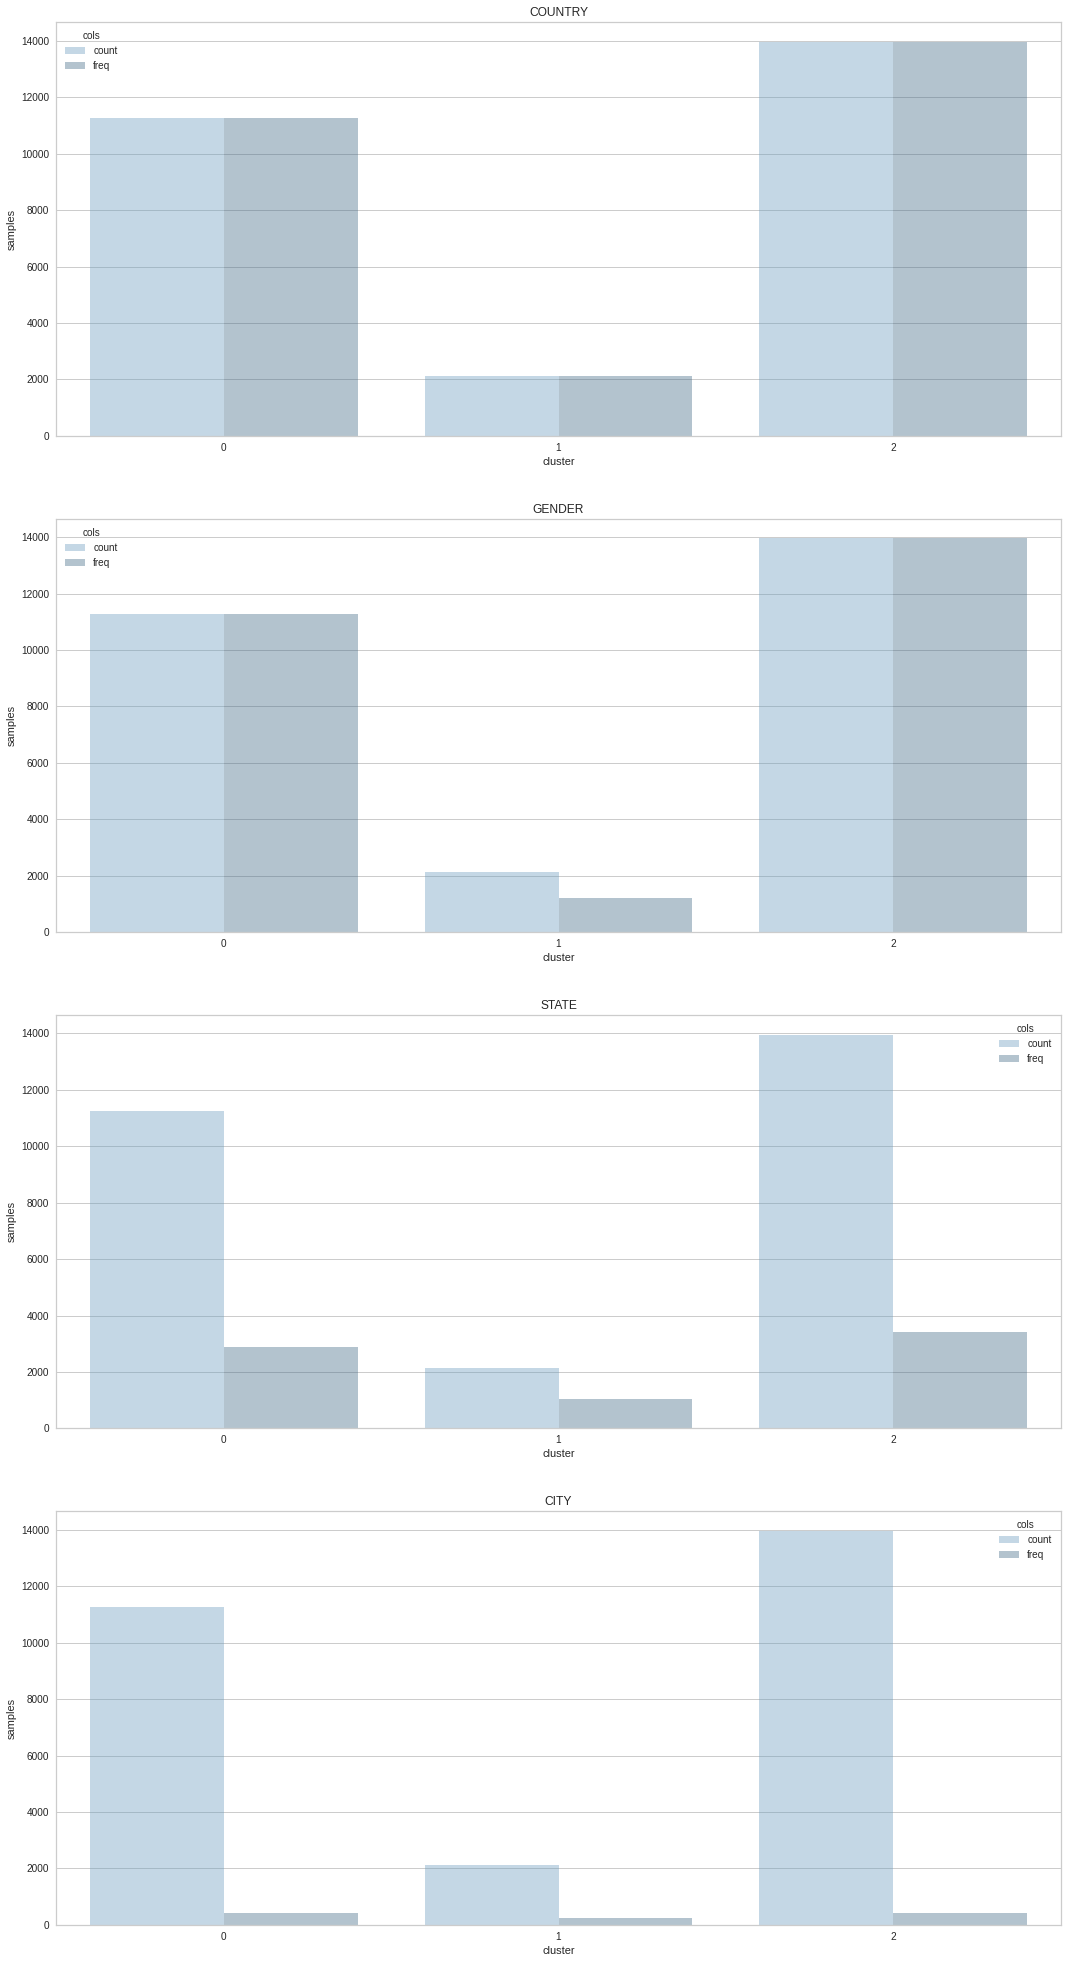

In [ ]:
check_insight(insight)

We can see that in feature `country` and `gender`, numbers of most-appear feature is a same with total samples in specific clusters.

Check with dataframe `insight` , we can see that:

1.   cluster 0 only inclue `gender` = Female,  and `country` = USA
2.   cluster 2 only inclue `gender` = Male,  and `country` = USA

This will reduce the important of other features like `state` or `city`


###Use for prediction

We have enough ingredients to predict many infomations about person relate to marathon

Assume that we have this data about person:

In [ ]:
df_person_info = df4[['name','gender','age','country','city','state']]
df_person_info

,name,gender,age,country,city,state
0,"Hall, Ryan",M,31,USA,Redding,CA
1,"Linden, Desiree",F,30,USA,Rochester Hills,MI
2,"Flanagan, Shalane",F,32,USA,Portland,OR
3,"Abdirahman, Abdi",M,35,USA,Tucson,AZ
4,"Keflezighi, Meb",M,38,USA,San Diego,CA
...,...,...,...,...,...,...
27356,"Anderson, Steve K.",M,32,USA,Larkspur,CA
27357,"McCarthy, Michael P.",M,34,USA,Norwell,MA
27358,"Brimmer, Delia C.",F,21,USA,West Simsbury,CT
27359,"Morganthal, Amy",F,38,USA,North Andover,MA


After using model `cluster_model`, We will have a data that labeled:

In [ ]:
df_person_info[['cluster','percent_cluster']] = df4[['cluster','percent_cluster']]

In [ ]:
df_person_info

,name,gender,age,country,city,state,cluster,percent_cluster
0,"Hall, Ryan",M,31,USA,Redding,CA,2,51.025182
1,"Linden, Desiree",F,30,USA,Rochester Hills,MI,0,41.171741
2,"Flanagan, Shalane",F,32,USA,Portland,OR,0,41.171741
3,"Abdirahman, Abdi",M,35,USA,Tucson,AZ,2,51.025182
4,"Keflezighi, Meb",M,38,USA,San Diego,CA,2,51.025182
...,...,...,...,...,...,...,...,...
27356,"Anderson, Steve K.",M,32,USA,Larkspur,CA,2,51.025182
27357,"McCarthy, Michael P.",M,34,USA,Norwell,MA,2,51.025182
27358,"Brimmer, Delia C.",F,21,USA,West Simsbury,CT,0,41.171741
27359,"Morganthal, Amy",F,38,USA,North Andover,MA,0,41.171741


Recall that we have `df_bycluster2` that included mean values of all supervise features:

In [ ]:
df_bycluster2

,cluster,10k,division,25k,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,age,percent_cluster
0,0,52.917228,1888.130581,136.418772,244.303661,6484.903684,198.919675,17172.930315,9.326208,166.899719,26.332346,113.756180,107.762177,230.713735,39.792277,41.171741
1,1,49.424956,1154.593911,126.772501,227.814604,6988.703044,184.812450,13580.409836,8.697222,155.037255,24.623977,105.918052,100.343644,214.788689,47.028103,7.803077
2,2,49.286995,1796.564286,126.699694,230.972605,8663.254280,186.177461,13685.012177,8.817674,155.414152,24.580988,105.654162,100.061282,217.516083,43.722083,51.025182


Finally, we join each other by `cluster`:

In [ ]:
df_bycluster.rename(columns={'age' : 'age_avg'}, inplace=True)

In [ ]:
df_final = pd.merge(df_person_info, df_bycluster.drop('percent_cluster',axis=1), left_on='cluster', right_on='cluster', how='left')

In [ ]:
df_final

,name,gender,age,country,city,state,cluster,percent_cluster,10k,division,25k,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,age_avg
0,"Hall, Ryan",M,31,USA,Redding,CA,2,51.025182,49.286995,1796.564286,126.699694,230.972605,8663.254280,186.177461,13685.012177,8.817674,155.414152,24.580988,105.654162,100.061282,217.516083,43.722083
1,"Linden, Desiree",F,30,USA,Rochester Hills,MI,0,41.171741,52.917228,1888.130581,136.418772,244.303661,6484.903684,198.919675,17172.930315,9.326208,166.899719,26.332346,113.756180,107.762177,230.713735,39.792277
2,"Flanagan, Shalane",F,32,USA,Portland,OR,0,41.171741,52.917228,1888.130581,136.418772,244.303661,6484.903684,198.919675,17172.930315,9.326208,166.899719,26.332346,113.756180,107.762177,230.713735,39.792277
3,"Abdirahman, Abdi",M,35,USA,Tucson,AZ,2,51.025182,49.286995,1796.564286,126.699694,230.972605,8663.254280,186.177461,13685.012177,8.817674,155.414152,24.580988,105.654162,100.061282,217.516083,43.722083
4,"Keflezighi, Meb",M,38,USA,San Diego,CA,2,51.025182,49.286995,1796.564286,126.699694,230.972605,8663.254280,186.177461,13685.012177,8.817674,155.414152,24.580988,105.654162,100.061282,217.516083,43.722083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27356,"Anderson, Steve K.",M,32,USA,Larkspur,CA,2,51.025182,49.286995,1796.564286,126.699694,230.972605,8663.254280,186.177461,13685.012177,8.817674,155.414152,24.580988,105.654162,100.061282,217.516083,43.722083
27357,"McCarthy, Michael P.",M,34,USA,Norwell,MA,2,51.025182,49.286995,1796.564286,126.699694,230.972605,8663.254280,186.177461,13685.012177,8.817674,155.414152,24.580988,105.654162,100.061282,217.516083,43.722083
27358,"Brimmer, Delia C.",F,21,USA,West Simsbury,CT,0,41.171741,52.917228,1888.130581,136.418772,244.303661,6484.903684,198.919675,17172.930315,9.326208,166.899719,26.332346,113.756180,107.762177,230.713735,39.792277
27359,"Morganthal, Amy",F,38,USA,North Andover,MA,0,41.171741,52.917228,1888.130581,136.418772,244.303661,6484.903684,198.919675,17172.930315,9.326208,166.899719,26.332346,113.756180,107.762177,230.713735,39.792277
